In [1]:
import cv2, os, numpy as np
import matplotlib.pyplot as plt

# ---------- Haar cascade ----------
def load_face_cascade():
    candidates = [
        "models/haarcascade_frontalface_default.xml",
        os.path.join(os.getcwd(), "haarcascade_frontalface_default.xml"),
        os.path.join(cv2.data.haarcascades, "haarcascade_frontalface_default.xml"),
    ]
    for p in candidates:
        if os.path.exists(p):
            c = cv2.CascadeClassifier(p)
            if not c.empty():
                return c
    raise IOError("Haar cascade not found. Put 'haarcascade_frontalface_default.xml' in ./models/ or project root.")

_FACE_CASCADE = load_face_cascade()

def detect_largest_face_bgr(bgr_img, scaleFactor=1.1, minNeighbors=5):
    if bgr_img is None: return None, None
    gray = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)
    faces = _FACE_CASCADE.detectMultiScale(gray, scaleFactor, minNeighbors)
    if len(faces) == 0: return None, None
    (x, y, w, h) = max(faces, key=lambda r: r[2]*r[3])
    return (x, y, w, h), bgr_img[y:y+h, x:x+w]


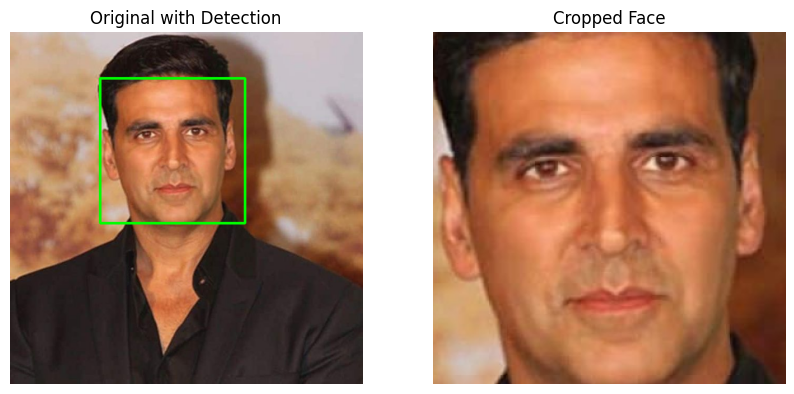

In [3]:
# ==== Test face detection and cropping ====
# Path to your test image
img_path = r"C:\Users\jians\Documents\GitHub\SMART-Barcode-Scanner-and-Face-Recognition\data_raw\Akshay Kumar\Akshay Kumar_1.jpg"   # <-- change this to your own image
bgr = cv2.imread(img_path)
if bgr is None:
    raise FileNotFoundError(f"Cannot read image: {img_path}")

# Detect face
(box, crop) = detect_largest_face_bgr(bgr)

if crop is None:
    print("❌ No face detected!")
else:
    x, y, w, h = box
    # Draw rectangle on original
    bgr_box = bgr.copy()
    cv2.rectangle(bgr_box, (x,y), (x+w, y+h), (0,255,0), 3)

    # Show side-by-side
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(bgr_box, cv2.COLOR_BGR2RGB))
    plt.title("Original with Detection")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
    plt.title("Cropped Face")
    plt.axis("off")

    plt.show()


In [ ]:
## testing purpose

In [6]:
# === Cell 0: Imports & config ===
import os, cv2, math, shutil, random, glob, time
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms as T

from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_fscore_support

# Paths (edit these)
RAW_DIR   = Path(r"C:\Users\jians\Documents\GitHub\SMART-Barcode-Scanner-and-Face-Recognition\data_raw")     # your folder-per-person raw images
PROC_DIR  = Path(r"C:\Users\jians\Documents\GitHub\SMART-Barcode-Scanner-and-Face-Recognition\data\data_proc")    # will be created: train/val/test subfolders
CASCADE   = cv2.data.haarcascades + "haarcascade_frontalface_default.xml"

# Splits
SPLIT = dict(train=0.70, val=0.15, test=0.15)
assert abs(sum(SPLIT.values()) - 1.0) < 1e-6

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)


Device: cpu


In [7]:
# === Cell 1: Haar detect, quality checks & repair, crop ===
# Load Haar cascade
_FACE = cv2.CascadeClassifier(CASCADE)
if _FACE.empty():
    raise IOError("Haar cascade not found. Check CASCADE path.")

def detect_largest_face_bgr(bgr_img, scaleFactor=1.1, minNeighbors=5):
    if bgr_img is None: return None, None
    gray = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)
    faces = _FACE.detectMultiScale(gray, scaleFactor, minNeighbors)
    if len(faces) == 0: return None, None
    (x, y, w, h) = max(faces, key=lambda r: r[2]*r[3])
    return (x, y, w, h), bgr_img[y:y+h, x:x+w]

# Quality metrics
def lap_var(gray):  # blur score
    return cv2.Laplacian(gray, cv2.CV_64F).var()

# Repair helpers
def auto_gamma(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    m = gray.mean() + 1e-6
    gamma = np.clip(np.log(128.0)/np.log(m), 0.5, 2.0)
    lut = np.array([((i/255.0)**gamma)*255 for i in range(256)]).astype("uint8")
    return cv2.LUT(img, lut)

def clahe_bgr(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l,a,b = cv2.split(lab)
    l = cv2.createCLAHE(2.0,(8,8)).apply(l)
    return cv2.cvtColor(cv2.merge([l,a,b]), cv2.COLOR_LAB2BGR)

def unsharp(img, amt=0.7, rad=1.5):
    blur = cv2.GaussianBlur(img, (0,0), rad)
    return cv2.addWeighted(img, 1+amt, blur, -amt, 0)

def soft_repair(bgr):
    """Try to improve brightness/contrast and mild blur; return repaired image."""
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    m, s, v = gray.mean(), gray.std(), lap_var(gray)
    # brightness/contrast
    if (m < 60 or m > 190) or (s < 25):
        bgr = clahe_bgr(auto_gamma(bgr))
        gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY); m, s = gray.mean(), gray.std()
    # blur
    if v < 80:
        bgr = unsharp(bgr, amt=0.7, rad=1.5)
    return bgr

def crop_and_repair(bgr, min_face=80, out_size=112):
    """Detect largest face, soft-repair, resize to out_size."""
    box, face = detect_largest_face_bgr(bgr)
    if face is None: return None
    # attempt repair
    face = soft_repair(face)
    h,w = face.shape[:2]
    if min(h,w) < min_face:
        # upscale a bit if only slightly small
        scale = max(min_face/min(h,w), 1.0)
        if scale > 1.6:  # too small -> not useful
            return None
        face = cv2.resize(face, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_LANCZOS4)
    # final resize for CNN
    face = cv2.resize(face, (out_size, out_size), interpolation=cv2.INTER_AREA)
    return face


In [8]:
# === Cell 2: Build processed dataset with splits ===
def make_clean_dir(path: Path):
    if path.exists(): shutil.rmtree(path)
    path.mkdir(parents=True, exist_ok=True)

def split_indices(n, train_p, val_p, test_p):
    idx = list(range(n))
    random.shuffle(idx)
    n_train = int(n*train_p)
    n_val   = int(n*val_p)
    train_idx = idx[:n_train]
    val_idx   = idx[n_train:n_train+n_val]
    test_idx  = idx[n_train+n_val:]
    return train_idx, val_idx, test_idx

def build_processed_dataset(raw_dir=RAW_DIR, proc_dir=PROC_DIR, out_size=112):
    print("Building processed dataset...")
    make_clean_dir(proc_dir)
    for split in ["train","val","test"]:
        (proc_dir/split).mkdir(parents=True, exist_ok=True)

    persons = sorted([p for p in raw_dir.iterdir() if p.is_dir()])
    kept, skipped = 0, 0

    for person_dir in persons:
        images = []
        for ext in ("*.jpg","*.jpeg","*.png","*.bmp","*.webp"):
            images += glob.glob(str(person_dir / ext))
        if len(images) < 2:
            print(f"Skipping '{person_dir.name}' (not enough images).")
            continue

        # crop/repair all first
        crops = []
        for path in images:
            bgr = cv2.imread(path)
            face = crop_and_repair(bgr, out_size=out_size)
            if face is not None:
                crops.append((path, face))
            else:
                skipped += 1

        if len(crops) < 2:
            print(f"Skipping '{person_dir.name}' (no usable faces).")
            continue

        # split indices on crops
        ti, vi, si = split_indices(len(crops), SPLIT["train"], SPLIT["val"], SPLIT["test"])
        for split, idxs in (("train",ti),("val",vi),("test",si)):
            outp = proc_dir / split / person_dir.name
            outp.mkdir(parents=True, exist_ok=True)
            for j,k in enumerate(idxs):
                _, img = crops[k]
                cv2.imwrite(str(outp / f"{j:05d}.jpg"), img)
                kept += 1

    print(f"Done. Kept: {kept} | Skipped: {skipped}")
    # quick sanity
    for split in ("train","val","test"):
        print(split, "classes:", len(list((proc_dir/split).glob("*"))))

# Run once (comment after built)
build_processed_dataset(out_size=112)


Building processed dataset...
Done. Kept: 2475 | Skipped: 87
train classes: 31
val classes: 31
test classes: 31


In [9]:
# === Cell 3: Datasets & DataLoaders ===
mean = [0.485,0.456,0.406]; std = [0.229,0.224,0.225]

train_tf = T.Compose([
    T.RandomResizedCrop(112, scale=(0.9,1.0)),
    T.RandomHorizontalFlip(0.5),
    T.ColorJitter(0.2,0.2),
    T.ToTensor(),
    T.Normalize(mean, std),
])

eval_tf = T.Compose([
    T.Resize(128), T.CenterCrop(112),
    T.ToTensor(),
    T.Normalize(mean, std),
])

train_ds = datasets.ImageFolder(PROC_DIR/"train", transform=train_tf)
val_ds   = datasets.ImageFolder(PROC_DIR/"val",   transform=eval_tf)
test_ds  = datasets.ImageFolder(PROC_DIR/"test",  transform=eval_tf)
NUM_CLASSES = len(train_ds.classes)
print("Classes:", NUM_CLASSES)

# Class-balanced sampler (optional but helpful if unbalanced)
labels = [y for _,y in train_ds.samples]
counts = np.bincount(labels, minlength=NUM_CLASSES)
class_w = 1.0 / (counts + 1e-9)
weights = [class_w[y] for y in labels]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

train_dl = DataLoader(train_ds, batch_size=32, sampler=sampler, num_workers=4, pin_memory=True)
val_dl   = DataLoader(val_ds,   batch_size=64, shuffle=False,  num_workers=4, pin_memory=True)
test_dl  = DataLoader(test_ds,  batch_size=64, shuffle=False,  num_workers=4, pin_memory=True)


Classes: 31


In [10]:
# === Cell 4: SmallFaceCNN model ===
class SmallFaceCNN(nn.Module):
    def __init__(self, num_classes, embed_dim=128, p_drop=0.3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 56x56

            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 28x28

            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),          # 256x1x1
        )
        self.dropout = nn.Dropout(p_drop)
        self.fc_embed = nn.Linear(256, embed_dim)
        self.fc_cls   = nn.Linear(embed_dim, num_classes)

    def forward(self, x, return_embed=False):
        x = self.features(x).flatten(1)      # (B,256)
        x = self.dropout(x)
        emb = self.fc_embed(x)               # (B,embed_dim)
        emb = F.normalize(emb, p=2, dim=1)   # L2-normalize for cosine
        logits = self.fc_cls(emb)
        if return_embed: return logits, emb
        return logits

model = SmallFaceCNN(NUM_CLASSES, embed_dim=128).to(DEVICE)
sum(p.numel() for p in model.parameters())/1e6


0.426271

In [ ]:
# === Cell 5: Train loop ===
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

def run_epoch(dl, train=True):
    model.train(train)
    total, correct, loss_sum = 0, 0, 0.0
    for x,y in dl:
        x,y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)
        loss = criterion(logits, y)
        if train:
            optimizer.zero_grad(); loss.backward(); optimizer.step()
        loss_sum += float(loss)*x.size(0)
        preds = logits.argmax(1)
        correct += int((preds==y).sum())
        total += x.size(0)
    return loss_sum/total, correct/total

best_val = 1e9; patience, bad = 6, 0
EPOCHS = 50
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(train_dl, True)
    val_loss, val_acc = run_epoch(val_dl, False)
    scheduler.step()
    print(f"epoch {epoch:02d} | train {tr_loss:.4f}/{tr_acc:.3f} | val {val_loss:.4f}/{val_acc:.3f}")
    if val_loss < best_val:
        best_val, bad = val_loss, 0
        torch.save(model.state_dict(), "best_cnn.pt")
    else:
        bad += 1
        if bad >= patience:
            print("Early stopping.")
            break


c:\Users\jians\Documents\GitHub\SMART-Barcode-Scanner-and-Face-Recognition\.venv\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\jians\AppData\Local\Temp\ipykernel_18060\2520420203.py:15: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:836.)
  loss_sum += float(loss)*x.size(0)


epoch 01 | train 3.4067/0.076 | val 3.3737/0.070
epoch 02 | train 3.3583/0.139 | val 3.3345/0.106
epoch 03 | train 3.3263/0.153 | val 3.3036/0.118
epoch 04 | train 3.2968/0.159 | val 3.2745/0.129
epoch 05 | train 3.2673/0.168 | val 3.2540/0.140
epoch 06 | train 3.2308/0.191 | val 3.2413/0.143
epoch 07 | train 3.1967/0.190 | val 3.1929/0.140
epoch 08 | train 3.1706/0.196 | val 3.1948/0.143
epoch 09 | train 3.1344/0.208 | val 3.1251/0.190
epoch 10 | train 3.1106/0.241 | val 3.1301/0.162
epoch 11 | train 3.0924/0.231 | val 3.0921/0.185
epoch 12 | train 3.0735/0.250 | val 3.0675/0.210
epoch 13 | train 3.0483/0.243 | val 3.0608/0.182
epoch 14 | train 3.0354/0.251 | val 3.0490/0.196
epoch 15 | train 3.0353/0.243 | val 3.0458/0.216
epoch 16 | train 3.0256/0.244 | val 3.0173/0.227
epoch 17 | train 3.0040/0.263 | val 3.0072/0.235
epoch 18 | train 3.0073/0.259 | val 3.0058/0.235
epoch 19 | train 3.0153/0.256 | val 3.0079/0.227
epoch 20 | train 3.0025/0.261 | val 3.0049/0.227
epoch 21 | train 2.9

In [ ]:
# === Cell 6: Test accuracy ===
model.load_state_dict(torch.load("best_cnn.pt", map_location=DEVICE))
test_loss, test_acc = run_epoch(test_dl, False)
print(f"TEST acc: {test_acc:.3f}")
